In [2]:
# loading required packages
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Flatten
from keras.metrics import Sum
import pandas as pd

# Oxford Pet Dataset- a ResNet/U-Net understanding

In [2]:
# importing oxford iii pet datasets
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

INFO[build.py]: Loading dataset oxford_iiit_pet:3.1.0 from imports: tensorflow_datasets.image_classification.oxford_iiit_pet


2021-11-11 17:52:27.653531: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-11-11 17:52:27.653570: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-11 17:52:30.018629: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2021-11-11 17:52:30.018866: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-11 17:52:30.022256: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DESKTOP-RDF3FSH
2021-11-11 17:52:30.022374: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: DESKTOP-RDF3FSH
W1111 17:52:30.022004  9600 download_and_prepare.py:42] ***`tfds build` should be used instead of `downloa

In [3]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='C:\\Users\\jkuhn\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
   

In [4]:
# extract an unseen dataset from test_dataset that will not be used in training
# we will take 10% of test dataset into an unseen dataset
dataset['unseen'] = dataset['test'].take(round(len(dataset['test'])*0.10))
dataset['test'] = dataset['test'].skip(round(len(dataset['test'])*0.10))
print('test random',len(dataset['test']))
print('unseen',len(dataset['unseen']))

test random 3302
unseen 367


In [5]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_unseen(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [6]:
train = dataset['train'].map(load_image_train)
unseen = dataset['unseen'].map(load_image_unseen)
test = dataset['test'].map(load_image_test)

In [7]:
BATCH_SIZE = 32

train_dataset = train.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)
unseen_dataset = unseen.batch(BATCH_SIZE)

In [8]:
def display(display_list,titles=[], display_string=None):
  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  plt.show()


def show_image_from_dataset(dataset):
  for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])

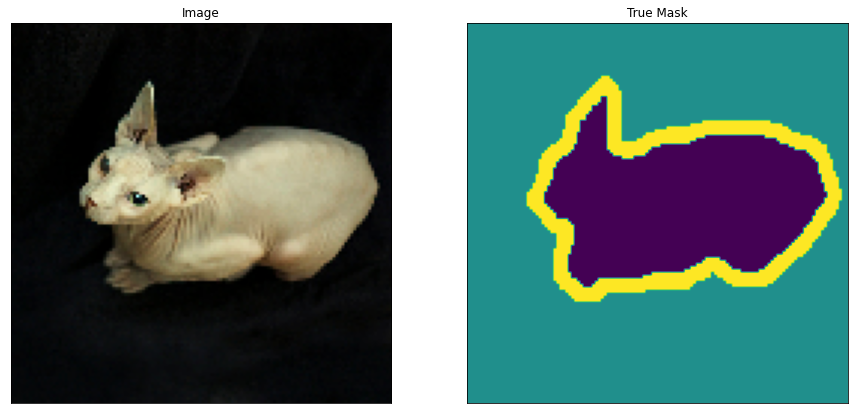

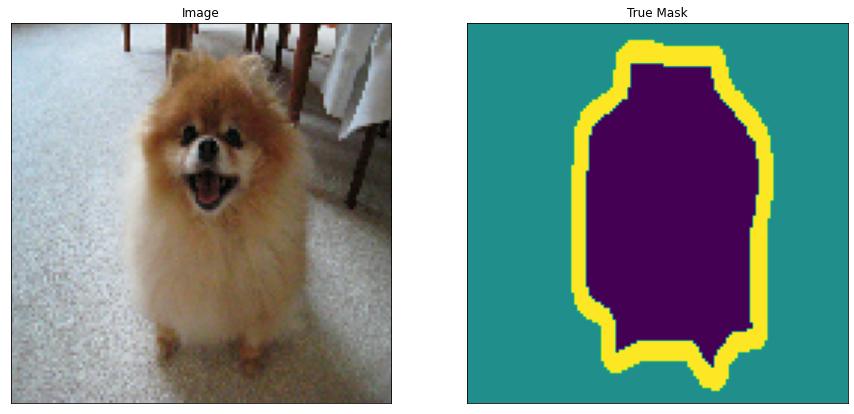

In [9]:
show_image_from_dataset(train)
show_image_from_dataset(test)

# ResNet model

In [76]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_40[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [81]:
from keras.applications.resnet import ResNet50
output_channels = 3
base_model=ResNet50(include_top = False, weights = None,
                        input_shape = (128, 128, 3))

resnet50_model = tf.keras.models.Sequential()
resnet50_model.add(base_model)
resnet50_model.add(tf.keras.layers.Conv2DTranspose(filters = 128,
                                         kernel_size = (3,3),
                                          strides = (32,32),
                                         kernel_initializer = 'he_normal',
                                         padding = 'same'))
resnet50_model.add(tf.keras.layers.Activation('relu'))
resnet50_model.add(tf.keras.layers.Conv2D(3, (1,1), activation = 'softmax'))
resnet50_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 128, 128, 128)     2359424   
_________________________________________________________________
activation_6 (Activation)    (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 128, 128, 3)       387       
Total params: 25,947,523
Trainable params: 25,894,403
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
%%time
import keras

#callbacks are passed to the model via the callbacks argument in fit, 
# which takes a list of callbacks. You can pass any number of callbacks.
callbacks_list = [
    keras.callbacks.EarlyStopping(      # interupts training when improvement stops
    monitor = 'accuracy',  # monitors the model's validation accuracy
    patience = 3), # interrupts training when accuracy has stopped improving for more than 3 epoch
    keras.callbacks.ModelCheckpoint(  # saves the current weights after every epoch
    filepath = 'simpleUNet_model.h5',   # path to the destination model file
    monitor = 'val_loss',
    save_best_only = True)]   # these two arguments mean you won't overwrite the model file unless val_loss has improved, which allows you to keep the best model seen during training.

EPOCHS = 10  # in the interest of time

# get model
resnet50_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
resnet50_model_history = resnet50_model.fit(train_dataset, 
                                                epochs=EPOCHS, 
                                                callbacks = callbacks_list, 
                                                validation_data=test_dataset)  

Epoch 1/10
 18/115 [===>..........................] - ETA: 5:28 - loss: 1.0794 - accuracy: 0.5641

In [13]:
import keras
model_simpleunet.save('simple_unet_test2.h5')
model_simpleunet = keras.models.load_model('simple_unet_test2.h5')

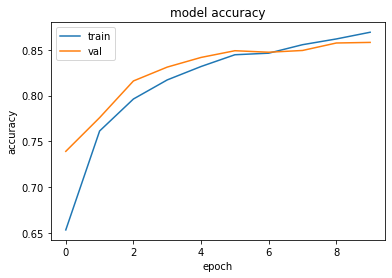

In [53]:
plt.plot(model_simpleunet_history.history['accuracy'])
plt.plot(model_simpleunet_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

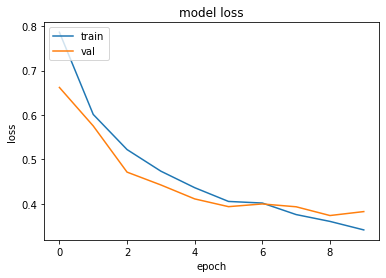

In [54]:
plt.plot(model_simpleunet_history.history['loss'])
plt.plot(model_simpleunet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [84]:
integer_slider = round(len(dataset['test'])*0.10)

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model_simpleunet.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

def get_image_and_annotation_arrays(dataset):
  ds = dataset.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)
  
  images = []
  y_true_segments = []

  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()
  
  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
  
  return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments

def display(display_list,titles=[], display_string=None):
  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  plt.show()

#https://www.jeremyjordan.me/evaluating-image-segmentation-models/
def iou_score(target, pred):  
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [92]:
# getting the accuracy and jaccard index on train, test, and unseen
from sklearn.metrics import accuracy_score

trained_predictions = model_simpleunet.predict(train_dataset)
test_predictions = model_simpleunet.predict(test_dataset)
unseen_predictions = model_simpleunet.predict(unseen_dataset)

train_image, train_mask = get_image_and_annotation_arrays(train_dataset)
test_image, test_mask = get_image_and_annotation_arrays(test_dataset)
unseen_image, unseen_mask = get_image_and_annotation_arrays(unseen_dataset)

# train_set
print('train IoU: ', iou_score(train_mask, trained_predictions))

# test_set
print('test IoU: ', iou_score(test_mask, test_predictions))

# unseen dataset
print('unseen IoU: ', iou_score(unseen_mask, unseen_predictions))

ValueError: operands could not be broadcast together with shapes (3648,128,128,1) (3680,128,128,3) 

In [80]:
iou_score(y_true_segments,unseen_predictions)

0.6972134041851158

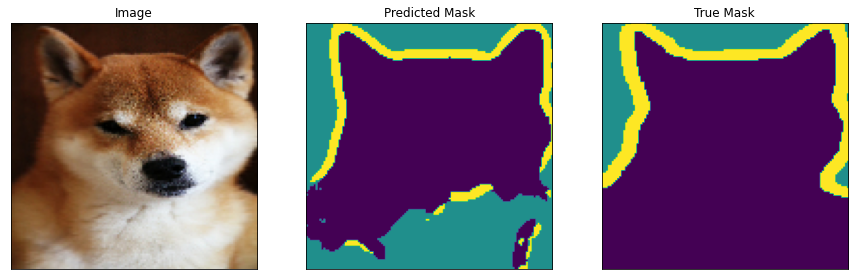

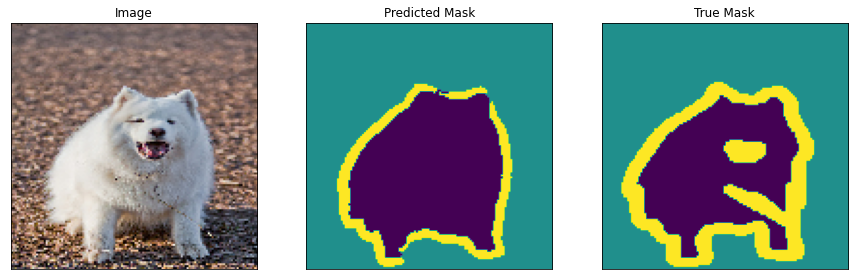

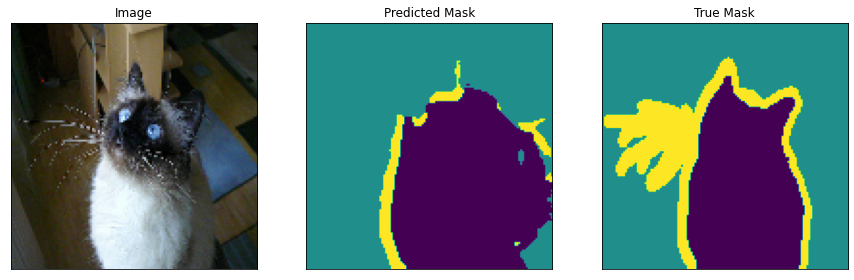

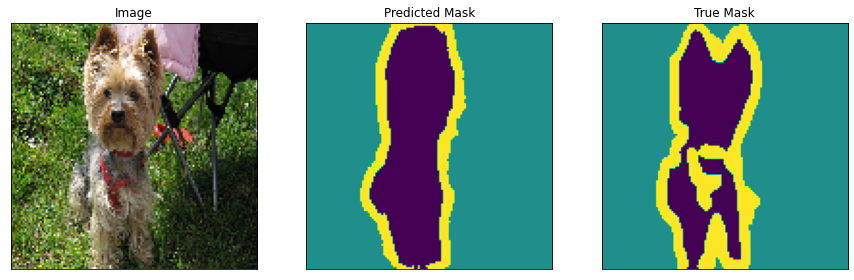

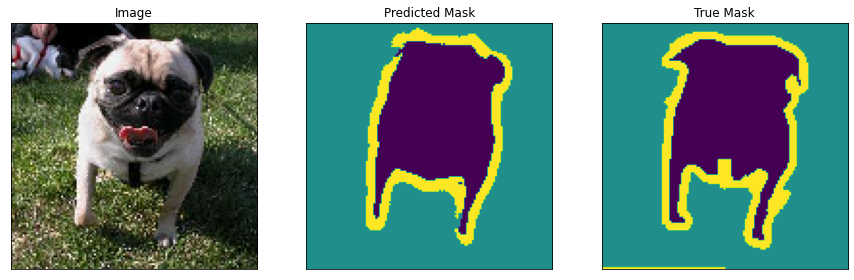

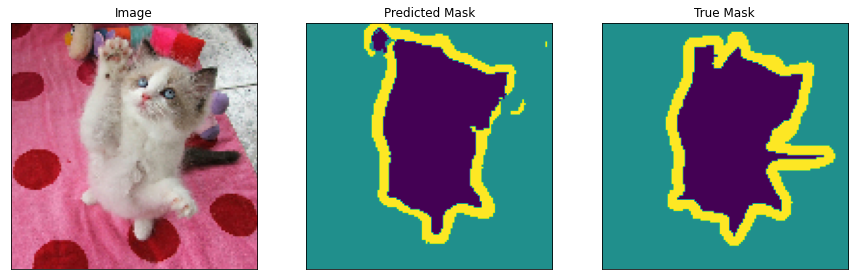

In [56]:
image_num = [15, 28, 32, 50, 72, 80]

for i in image_num:
    y_true_images, y_true_segments = get_test_image_and_annotation_arrays()
    y_pred_mask = make_predictions(y_true_images[i], y_true_segments[i])
    display([y_true_images[i], y_pred_mask, y_true_segments[i]], ["Image", "Predicted Mask", "True Mask"])

In [58]:
# seeing what each layer found
# https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md
# https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0

from keras import models

layer_outputs = [layer.output for layer in model_simpleunet.layers] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model_simpleunet.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

image_num = [15, 28, 32, 50, 72, 80]

for i in image_num:
    y_true_images, y_true_segments = get_test_image_and_annotation_arrays()
    activations = activation_model.predict(y_true_images[i]) 
    # Returns a list of five Numpy arrays: one array per layer activation

    layer_names = []
    for layer in model_simpleunet.layers:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
    images_per_row = 5

    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

ValueError: in user code:

    C:\Users\jkuhn\anaconda_new\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    C:\Users\jkuhn\anaconda_new\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\jkuhn\anaconda_new\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\jkuhn\anaconda_new\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\jkuhn\anaconda_new\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\jkuhn\anaconda_new\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    C:\Users\jkuhn\anaconda_new\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    C:\Users\jkuhn\anaconda_new\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\jkuhn\anaconda_new\lib\site-packages\keras\engine\input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_3: expected shape=(None, 128, 128, 3), found shape=(32, 128, 3)


In [3]:
# UNet Encoder
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
        x = tf.keras.layers.Activation('relu')(x)
    return x
    
def encoder_block(inputs, n_filters = 64, pool_size = (2,2), dropout = 0.3):
    f = conv2d_block(inputs, n_filters = n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def encoder(inputs):
    f1,p1=encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
    f2,p2=encoder_block(p1, n_filters=128, pool_size=(2,2), dropout = 0.3)
    f3,p3 = encoder_block(p2, n_filters = 256, pool_size=(2,2), dropout=0.3)
    f4,p4 = encoder_block(p3, n_filters = 512, pool_size=(2,2), dropout=0.3)
    return p4, (f1, f2, f3, f4)

# adding a bottleneck output
def bottleneck(inputs):
    bottle_neck = conv2d_block(inputs, n_filters = 1024)
    return bottle_neck

# adding a decoder
def decoder_block(inputs,
                  conv_output, n_filters = 64, kernel_size = 3,
                  strides = 3, dropout = 0.3):
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size = 3)
    return c

def decoder(inputs, convs, output_channels):
    f1, f2, f3, f4 = convs
    
    c6 = decoder_block(inputs, f4, n_filters=512, kernel_size = (3,3), strides = (2,2), dropout = 0.3)
    c7 = decoder_block(c6, f3, n_filters = 256, kernel_size = (3,3), strides = (2,2), dropout = 0.3)
    c8 = decoder_block(c7, f2, n_filters = 128, kernel_size = (3,3), strides = (2,2), dropout = 0.3)
    c9 = decoder_block(c8, f1, n_filters = 64, kernel_size = (3,3), strides = (2,2), dropout = 0.3)
    outputs = tf.keras.layers.Conv2D(output_channels, (1,1), activation = 'softmax')(c9)
    return outputs

# creating the model

OUTPUT_CHANNELS = 3

def unet():
    inputs = tf.keras.layers.Input(shape = (128, 128, 3,))
    encoder_output, convs = encoder(inputs)
    bottle_neck = bottleneck(encoder_output)
    outputs = decoder(bottle_neck, convs, output_channels = OUTPUT_CHANNELS)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    return model

model_simpleunet = unet()
model_simpleunet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

In [4]:
def unet():
    inputs = tf.keras.layers.Input(shape = (128, 128, 3,))
    encoder_output, convs = encoder(inputs)
    #bottle_neck = bottleneck(encoder_output)
    #outputs = decoder(bottle_neck, convs, output_channels = OUTPUT_CHANNELS)
    #model = tf.keras.Model(inputs = inputs, outputs = outputs)
    return convs

convs = unet()
convs

(<KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'activation_19')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'activation_21')>,
 <KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'activation_23')>,
 <KerasTensor: shape=(None, 16, 16, 512) dtype=float32 (created by layer 'activation_25')>)